## Install core dependencies

In [1]:
!pip install numpy scipy matplotlib torch tntorch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## Install mandatory libs

In [2]:
!pip install einops numba opt_einsum

## Install optional libs

In [3]:
!pip install maxvolpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Utils

#### Config

In [4]:
__COMP_ACC = 1e-12
__BD_LIMIT = None
__ARCH_2D = "stacked"
__parameters = {"a": 0.0, "b": 2.0, "L": 8}


def COMP_ACC():
    return __COMP_ACC

def BD_LIMIT() -> int:
    return __BD_LIMIT


def ARCH_2D():
    return __ARCH_2D


def parameters(key=None):
    if key in ["ax", "bx", "ay", "by", "Lx", "Ly"] and key not in __parameters.keys():
        return __parameters[key[0]]
    elif key is not None:
        return __parameters[key]
    return __parameters


#### Mod

In [5]:
def set_arch(arch):
    if arch in ["stacked", "sequential", "xyrev", "xrevy"]:
        __ARCH_2D = arch
    else:
        raise ValueError(f"{arch} not in [stacked,sequential,xyrev,xrevy]")


def set_accuracy(accuracy):
    __COMP_ACC = accuracy


def set_bd_limit(limit: int):
    __BD_LIMIT = limit


def set_param(key, value):
    __parameters[str(key)] = value

#### Utilities

In [6]:
import pickle
from typing import Callable
from warnings import warn
import functools

import numpy as np
import torch
from numba import njit
from numpy.typing import NDArray
import opt_einsum as oe

def save_object(obj, filename):
    try:
        with open(filename, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)


def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)


@njit
def svd(M: NDArray, eps: float = None, bdmax: int = None):
    U, S, V = np.linalg.svd(M, full_matrices=False)
    S_n = S / np.sqrt(np.sum(S**2))
    if eps is not None:
        trunc = np.sum(np.cumsum(S_n[::-1] ** 2) >= eps)
        trunc = max(1,trunc)
        bd = min(trunc, bdmax) if bdmax is not None else trunc
    else:
        bd = len(S) if bdmax is None else min(len(S), bdmax)
    return U[:, :bd], S[:bd], V[:bd, :]


@njit
def svd_3dwrap(tensor, full_matrices):
    U, S, V = np.linalg.svd(tensor[0], full_matrices=full_matrices)
    Uf = np.expand_dims(U, axis=0)
    Sf = np.expand_dims(S, axis=0)
    Vf = np.expand_dims(V, axis=0)
    for i in range(1, tensor.shape[0]):
        U, S, V = np.linalg.svd(tensor[i], full_matrices=full_matrices)
        Uf = np.concatenate((Uf, np.expand_dims(U, axis=0)))
        Sf = np.concatenate((Sf, np.expand_dims(S, axis=0)))
        Vf = np.concatenate((Vf, np.expand_dims(V, axis=0)))

    return Uf, Sf, Vf


def schmidt_coeffs(M: NDArray):
    # TODO Add methods for MPS and MPO.
    S = np.linalg.svd(M, full_matrices=False, compute_uv=False)
    S_n = S / np.sqrt(np.sum(S**2))
    return S_n



def validate_nodes(nodes):
    if nodes[0].boundary is None:
        nodes[0].boundary = "left"
    if nodes[-1].boundary is None:
        nodes[-1].boundary = "right"
    for node in nodes[1:-1]:
        node.boundary = None
    return nodes


def cal_padding(shape1, shape2, pad_axis=[0]):
    pad1, pad2 = [], []
    for ix, (x, y) in enumerate(zip(shape1, shape2)):
        if ix in pad_axis:
            pad1.append((0, y))
            pad2.append((x, 0))
        else:
            pad1.append((0, 0))
            pad2.append((0, 0))
    return pad1, pad2


def val_addability(self, other, p_axis=1):
    assert self.order == other.order, (
        "Only tensors of same order can be added."
        + "Received {} and {} -order tensors".format(self.order, other.order)
    )
    assert (
        self.dim[p_axis] == other.dim[p_axis]
    ), "Failed to add coz of mismatched shape on the physical leg(s)"

    return (self.order == other.order) and self.dim[p_axis] == other.dim[p_axis]


def gen_state(d: int, L: int):
    warn("Caution while calling for this. It will use exponentially large memory.")
    np.random.seed(42)
    return np.random.randn(d**L)


def get_ls(gs: int, nofq: int):
    return [int(x) for x in list(np.binary_repr(gs, width=nofq))]


def discretize(f: Callable, mesh: NDArray):
    function_values = f(mesh)
    return function_values


def unshuffle_axis(A: NDArray, L: int):
    # tensorize A and unshuffle odd and even axis and return a matrix
    axis_even_odd = [x for x in range(2 * L) if x % 2 == 1] + [
        x for x in range(2 * L) if x % 2 == 0
    ]
    A = A.reshape([2] * 2 * L).transpose(axis_even_odd).reshape(2**L, 2**L)
    return A


def shuffle_axis(A: NDArray, L: int):
    # tensorize A and shuffle odd and even axis and return a matrix
    new_axis = []
    for x in range(L):
        new_axis += [x, x + L]
    A = A.reshape([2] * 2 * L).transpose(new_axis).reshape(2**L, 2**L)
    return A


def reflect_yaxis(A, L: int):
    x_reflect_y = [0] + [x for x in range(1, L + 1)][::-1]
    A = A.reshape([2**L] + [2] * L).transpose(x_reflect_y).reshape(2**L, 2**L)
    return A


def reflect_xaxis(A, L: int):
    reflect_x_y = [x for x in range(L)][::-1] + [L + 1]
    A = A.reshape([2] * L + [2**L]).transpose(reflect_x_y).reshape(2**L, 2**L)
    return A


# Decorators

def qubits_to_coordinates(qubits, L, axis=None):
    a = parameters(f"a{axis}")
    b = parameters(f"b{axis}")
    pows = 2**np.arange(L-1,-1,-1).reshape(L,1)
    ints = (qubits*pows).sum(0)
    ints /= 2**L
    ints *= b - a
    ints += a
    return ints


def modify_input(function):
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        args_ = [list(k) for _, k in enumerate(zip(*args))]
        x = qubits_to_coordinates(args_, len(args))
        val = function(x, **kwargs)
        return val

    return wrapper


def modify_2inputs(function):
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        L1 = int(len(args) / 2)
        if "Lx" in parameters().keys() and "Ly" in parameters().keys():
            Lx = parameters("Lx")
            Ly = parameters("Ly")
        else:
            Lx = L1
            Ly = L1
        args = torch.stack(args)
        if ARCH_2D() == "stacked":
            args_x = args[:Lx,:]
            args_y = args[Lx:,:]
        elif ARCH_2D() == "sequential":
            assert (
                Lx == Ly
            ), "For sequential architechture, only equal no of qubits in x and y are supported."
            args_x = args[: 2 * Lx : 2,:]
            args_y = args[1 : 2 * Ly : 2, :]
        elif ARCH_2D() == "xyrev":
            args_x = args_x[:Lx,:]
            args_y = torch.flip(args[Lx:,:],(0,))
        elif ARCH_2D() == "xrevy":
            args_x = torch.flip(args_x[:Lx,:],(0,))
            args_y = args[Lx:,:]
        x = qubits_to_coordinates(args_x, Lx, axis="x")
        y = qubits_to_coordinates(args_y, Ly, axis="y")
        val = function(x, y, **kwargs)
        return val

    return wrapper


# Network Contraction Utils


def partial_ip_path(mps1, mps2, skip_index):
    part_ip_path = ""
    output_path = "->"
    shapes = []
    L = len(mps1)
    for i in range(L):
        shape1 = mps1[i].shape
        shape2 = mps2[i].shape
        j = 3 * (i + 1)
        ll, ul, m, lr, ur = (oe.get_symbol(i) for i in (j - 3, j - 2, j - 1, j, j + 1))

        if i in skip_index:
            shapes.append(shape1)
            part_ip_path += "{}{}{},".format(ll, m, lr)
            output_path += "{}{}{}".format(ul, m, ur)
        else:
            shapes.append(shape1)
            shapes.append(shape2)
            part_ip_path += "{}{}{},{}{}{},".format(ll, m, lr, ul, m, ur)

        if i == 0:
            output_path += "{}{}".format(ll, ul)
        if i == L - 1:
            output_path += "{}{}".format(ur, lr)
    for c in set(output_path):
        if output_path.count(f"{c}") > 1:
            output_path = output_path.replace(f"{c}", "")
    con_path = part_ip_path[:-1] + output_path
    optimizer = oe.RandomGreedy(parallel=True)
    pathr = oe.contract_expression(
        con_path, *shapes, optimize=optimizer, memory_limit='max_input'
    )
    return pathr


def partial_opip_path(mpo, mps1, mps2, skip_index):
    part_ip_path = ""
    output_path = "->"
    output_path1 = ""
    shapes = []
    L = len(mps1)
    for i in range(L):
        shape0 = mpo[i].shape
        shape1 = mps1[i].shape
        shape2 = mps2[i].shape
        j = 5 * (i + 1)
        ll, ml, ul, lm, um, lr, mr, ur = (
            oe.get_symbol(i)
            for i in (j - 5, j - 4, j - 3, j - 2, j - 1, j, j + 1, j + 2)
        )

        if i in skip_index:
            shapes.append(shape0)
            part_ip_path += "{}{}{}{},".format(ml, lm, mr, um)
            output_path1 += "{}{}{}".format(ll, lm, lr)
            output_path += "{}{}{}".format(ul, um, ur)
        else:
            shapes.append(shape1)
            shapes.append(shape0)
            shapes.append(shape2)
            part_ip_path += "{}{}{},{}{}{}{},{}{}{},".format(
                ll, lm, lr, ml, lm, mr, um, ul, um, ur
            )

        if i == 0:
            output_path1 += "{}{}{}".format(ll, ml, ul)
        if i == L - 1:
            output_path += "{}{}{}".format(lr, mr, ur)
    output_path += output_path1
    for c in set(output_path):
        if output_path.count(f"{c}") > 1:
            output_path = output_path.replace(f"{c}", "")
    con_path = part_ip_path[:-1] + output_path
    optimizer = oe.RandomGreedy(parallel=True)
    pathr = oe.contract_expression(
        con_path, *shapes, optimize=optimizer, memory_limit='max_input'
    )
    return pathr


def get_arrays_einsum(mpo, mps1, mps2, site_index):
    arrays1 = []
    arrays2 = []

    for i in range(len(mpo)):
        if i in site_index:
            arrays1.append(mps1[i].tensor)
            arrays2.append(mpo[i].tensor)
        else:
            arrays2.append(mps2[i].tensor)
            arrays2.append(mpo[i].tensor)
            arrays2.append(mps2[i].tensor)
            arrays1.append(mps1[i].tensor)
            arrays1.append(mps2[i].tensor)

    return arrays1, arrays2


## Networks

#### Base MPS

In [7]:
import warnings
from typing import Iterator, List, Union

import numpy as np
from scipy.linalg import rq
from einops import rearrange, einsum
from numpy.typing import NDArray


class MPS_Node:
    """
    `MPS_Node()` class has the attributes that determine an arbitrary node of an MPS.

    It holds a tensor, if the tensor is in left or right canonical form and
    the boundary condition of the node.
    - Periodic boundary conditions are yet to be implemented.

    The axes of the tensor are stored in the following order:
    A tensor T(l,d,r) is represented by:
    -l--T--r- with `d` being the physical leg (dimension of the hilbert space)

    """

    # TODO Implement Periodic Boundary Conditions

    def __init__(
        self,
        _tensor: NDArray = np.array([]),
        _canonical: str = "None",
        _boundary: str = None,
    ):
        self.tensor = _tensor
        self.canonical = _canonical
        self.boundary = _boundary

    def __getitem__(self, i):
        return MPS_Node(self.tensor[:, [i], :])

    def __repr__(self) -> str:
        return "Shape=" + str(self.shape) + " | Boundary Cond=" + str(self.boundary)

    def __add__(self, other: "MPS_Node"):
        """Direct sum of two MPS Nodes. The resulting State Vectors will be added per component.

        Args:
            other (MPS_Node)

        Raises:
            ValueError: If the other node if not compatible with the current node.
            Compatibility requires the tensors to have the same order and the same physical dimension.

        Returns:
            MPS_Node: The sum is returned in the MPS_Node format.
        """
        pad_axis = [0]
        if self.ndim == 4:
            pad_axis.append(3)
        if not val_addability(self, other):
            raise ValueError("Cannot add the given tensors")
        if self.boundary == "left":
            del pad_axis[0]
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=2
            )
            return MPS_Node(sumt, _boundary=self.boundary)
        elif self.boundary == "right":
            del pad_axis[0]
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=0
            )
            return MPS_Node(sumt, _boundary=self.boundary)
        elif self.boundary is None:
            padding1, padding2 = cal_padding(self.dim, other.dim, pad_axis)
            sumt = np.concatenate(
                (np.pad(self.tensor, padding1), np.pad(other.tensor, padding2)), axis=2
            )
            return MPS_Node(sumt, _boundary=self.boundary)

    def contract(
        self, other: "MPS_Node", einstr=["l b e, e q r->l b q r", "l b q r-> l (b q) r"]
    ):
        """Given two nodes, and einstein summation notation, contract the corresponding tensors and return the tensor.

        Args:
            other (MPS_Node): The second node to be contracted with the current node.
            einstr (list, optional): The Einstein Summation string,
                along with the rearrangement pattern for einops package.
                Defaults to ['l b e, e q r->l b q r','l b q r-> l (b q) r'].

        Returns:
            Tensor: Returns the contracted tensor (of data type that is used in the initialization of the MPS_Node.)
        """
        return rearrange(einsum(self.tensor, other.tensor, einstr[0]), einstr[1])

    def __mul__(self, other: Union[float, int, "MPS_Node"]):
        """Kronecker Product of two MPS_Nodes or Scalar multiplication of a single node.
        The resulting state vector will be either scaled by the scalar value
        or multiplied along each component with the other vector.


        Args:
            other (Union[float, MPS_Node]): If other is of type float, then it is used a scalar.

        Raises:
            TypeError: If the type of other is not float or MPS_Node.

        Returns:
            MPS_Node: The sum is returned in the MPS_Node format.
        """
        if isinstance(other, float):
            tensor = self.tensor * other
        elif isinstance(other, int):
            tensor = self.tensor * float(other)
        elif isinstance(other, MPS_Node):
            tensor = rearrange(
                einsum(self.tensor, other.tensor, "l q r,u q v->l u q r v"),
                "l u q r v -> (l u) q (r v)",
            )
        else:
            raise TypeError(
                "Expected type Float or MPS Node but got {} type variable for multiplication".format(
                    type(other)
                )
            )
        return MPS_Node(tensor, _boundary=self.boundary)

    def copy(self):
        """Returns a deep copy of the node with the same attributes."""
        return MPS_Node(self.tensor.copy(), self.canonical, self.boundary)

    def average(self, axis: int = 1):
        einstr = {
            0: "l q r->q r",
            1: "l q r->l r",
            2: "l q r->l q",
        }
        tensor = einsum(self.tensor, einstr[axis]) * (1.0 / self.shape[axis])
        return MPS_Node(tensor)

    @property
    def order(self):
        return len(self.tensor.shape)

    @property
    def ndim(self):
        return len(self.tensor.shape)

    @property
    def dim(self):
        return list(self.tensor.shape)

    @property
    def shape(self):
        return self.tensor.shape

    def reshape(self, shape):
        self.tensor = self.tensor.reshape(shape)


class MPS:
    """
    `MPS()` class to store and process a list of MPS_Nodes.
    """

    def __init__(
        self, nodes: list[MPS_Node] = None, validate: bool = True, eps_local=None
    ):
        if nodes is not None:
            if validate is True:
                self.nodes = validate_nodes(nodes)
            else:
                self.nodes = nodes
        else:
            self.nodes = []
        self.eps = eps_local

    def __len__(self):
        return self.nodes.__len__()

    def __repr__(self) -> str:
        return (
            str(type(self))
            + "| Length="
            + str(len(self))
            + " | Ranks="
            + str(self.ranks_list)
            + " | Canonical="
            + str(self.canonical_form)
        )

    def __getitem__(self, i):
        return self.nodes[i]

    def __setitem__(self, i, val):
        self.nodes[i] = val if isinstance(val, MPS_Node) else MPS_Node(val)

    def __iter__(self) -> Iterator[MPS_Node]:
        return iter(self.nodes)

    def get_elem(self, int_index: Union[int, list[int]]):
        if isinstance(int_index, int):
            indices = get_ls(int_index, len(self))
        else:
            indices = int_index
        for ix, x in enumerate(self):
            qix = indices[ix]
            if ix == 0:
                temp = x.copy()[qix]
            else:
                temp = MPS_Node(temp.contract(x[qix]))
        return temp.tensor.reshape(-1).item()

    def copy(self):
        """Returns a deep copy of the MPS"""
        mps_copy = MPS([node.copy() for node in self])
        return mps_copy

    def compress(self, accuracy: float = None, max_bd: int = BD_LIMIT()):
        if not accuracy:
            accuracy = self.eps
        if not accuracy:
            accuracy = COMP_ACC()

        self.right_canonical()
        d1 = self[0].shape[1]
        new_nodes = []
        for ix, node in enumerate(self):
            if ix == 0:
                U, S, V = svd(
                    rearrange(node.tensor, "l d r-> (l d) r"),
                    eps=accuracy,
                    bdmax=max_bd,
                )
                new_nodes.append(MPS_Node(rearrange(U, "(l d) r->l d r", d=d1), "left"))
            elif node.boundary is None:
                M = rearrange(
                    einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                    "l d r-> (l d) r",
                )
                U, S, V = svd(M, eps=accuracy, bdmax=max_bd)
                new_nodes.append(MPS_Node(rearrange(U, "(l d) r->l d r", d=d1), "left"))
            elif ix == len(self) - 1:
                new_nodes.append(
                    MPS_Node(
                        einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                        _boundary="right",
                    )
                )
            carry_over = np.diag(S) @ V
        self.nodes = validate_nodes(new_nodes)
        return self.copy()

    def right_canonical(self):
        carry_over = None
        if self.canonical_form != 0 or len(self) == 1:
            d1 = self[0].shape[1]
            new_nodes = []
            for _, node in enumerate(reversed(self)):
                if node.boundary == "right" or carry_over is None:
                    R, Q = rq(
                        rearrange(node.tensor, "l d r-> l (d r)"), mode="economic"
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "l (d r)->l d r", d=d1),
                            _canonical="right",
                            _boundary="right",
                        )
                    )
                    carry_over = R
                elif node.boundary is None:
                    R, Q = rq(
                        rearrange(
                            einsum(node.tensor, carry_over, "l d b, b r-> l d r"),
                            "l d r-> l (d r)",
                        ),
                        mode="economic",
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "l (d r)->l d r", d=d1), _canonical="right"
                        )
                    )
                    carry_over = R
                elif node.boundary == "left":
                    new_nodes.append(
                        MPS_Node(
                            einsum(node.tensor, carry_over, "l d b, b r-> l d r"),
                            _boundary="left",
                        )
                    )
                    carry_over = None
            self.nodes = new_nodes[::-1]
            return carry_over

    def left_canonical(self):
        carry_over = None
        if self.canonical_form != len(self) - 1 or len(self) == 1:
            d1 = self[0].shape[1]
            new_nodes = []
            for _, node in enumerate(self):
                if node.boundary == "left" or carry_over is None:
                    Q, R = np.linalg.qr(rearrange(node.tensor, "l d r-> (l d) r"))
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "(l d) r->l d r", d=d1),
                            _canonical="left",
                            _boundary="left",
                        )
                    )
                    carry_over = R
                elif node.boundary is None:
                    Q, R = np.linalg.qr(
                        rearrange(
                            einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                            "l d r-> (l d) r",
                        )
                    )
                    new_nodes.append(
                        MPS_Node(
                            rearrange(Q, "(l d) r->l d r", d=d1), _canonical="left"
                        )
                    )
                    carry_over = R
                elif node.boundary == "right":
                    new_nodes.append(
                        MPS_Node(
                            einsum(carry_over, node.tensor, "l b, b d r-> l d r"),
                            _boundary="right",
                        )
                    )
                    carry_over = None
            self.nodes = new_nodes
            return carry_over

    def mixed_canonical(self, index: int = None):
        if index is None:
            raise ValueError("Index value expected of type int, but received none.")
        if self.canonical_form is None:
            self.left_canonical()

        curind = self.canonical_form

        if curind < index:
            left_nodes = self[:curind]
            transform_nodes = self[curind:index]
            tensor = self[index].tensor
            right_nodes = self[index + 1 :]
            transform_nodes = MPS(transform_nodes, False)
            carry = transform_nodes.left_canonical()
            node = MPS_Node(
                einsum(carry, tensor, "l b, b d r -> l d r"), _canonical="None"
            )

            self.nodes = validate_nodes(
                left_nodes + transform_nodes.nodes + [node] + right_nodes
            )
        elif curind > index:
            left_nodes = self[:index]
            tensor = self[index].tensor
            transform_nodes = self[index + 1 : curind + 1]
            right_nodes = self[curind + 1 :]
            transform_nodes = MPS(transform_nodes, False)
            carry = transform_nodes.right_canonical()
            node = MPS_Node(
                einsum(tensor, carry, "l d b, b r -> l d r"), _canonical="None"
            )
            self.nodes = validate_nodes(
                left_nodes + [node] + transform_nodes.nodes + right_nodes
            )

    def contract(self):
        warnings.warn(
            "Careful while calling the method of contraction. This will lead to exponential memory usage",
            ResourceWarning,
        )
        for ix, x in enumerate(self):
            if ix == 0:
                temp = x.copy()
            else:
                temp = MPS_Node(temp.contract(x))
        vec = temp.tensor.reshape(-1)
        return vec

    def __add__(self, other: "MPS"):
        assert len(self) == len(
            other
        ), "Addition possible only with MPS of equal number of sites/nodes."
        sum_nodes = []
        for t1, t2 in zip(self, other):
            sum_nodes.append(t1 + t2)
        return MPS(sum_nodes).compress(COMP_ACC())

    def __mul__(self, other: Union[float, int, "MPS"]):
        if type(other) == MPS:
            assert len(self) == len(other), ...
            "Element-wise multiplication possible only with MPS of same shaped tensors."
            nodes = []
            for t1, t2 in zip(self, other):
                nodes.append(t1 * t2)
            return MPS(nodes).compress(COMP_ACC())
        elif type(other) == float or type(other) == int:
            prod = self.copy()
            prod[-1] = prod[-1] * other
            return prod

    def __matmul__(self, other: "MPS"):
        einstr = ["l d r, s d t->l s r t", "l s r t-> (l s) (r t)"]
        result = None
        for _, (node1, node2) in enumerate(zip(self, other)):
            if result is None:
                result = node1.contract(node2, einstr)
            else:
                result = einsum(result, node1.contract(node2, einstr), "a b,b c->a c")
        return result.item() if result is not None else RuntimeError()

    def inner_prod(self, other: "MPS"):
        return self @ other

    def partial_inner_prod(self):
        raise DeprecationWarning()

    def schmidt_coeffs(self):
        coeffs = []
        for ix, node in enumerate(self):
            self.mixed_canonical(ix)
            S = schmidt_coeffs(rearrange(node.tensor, "l d r-> (l d) r"))
            coeffs.append(S)
        return coeffs

    def ent_entropy(self):
        entropy = []
        for ix, node in enumerate(self):
            self.mixed_canonical(ix)
            S = schmidt_coeffs(rearrange(node.tensor, "l d r-> (l d) r"))
            entropy.append(-2.0 * np.dot(S**2, np.log2(S)).item())
        return entropy

    @property
    def ranks_list(self):
        return [node.dim[0] for node in self] + [self[-1].dim[2]]

    @property
    def max_rank(self):
        return np.max(np.array([node.dim[0] for node in self]))

    @property
    def norm(self):
        if self.canonical_form is None:
            self.left_canonical()
        node = self[self.canonical_form]
        trace = einsum(node.tensor, node.tensor, "l d r, l d r->")
        return np.sqrt(trace.item()).item()

    @property
    def canonical_form(self):
        a = np.array([node.canonical for node in self])
        ix = np.where(a == "None")[0]
        if len(ix) != 1:
            return None
        else:
            return ix.item()


def list_to_mps(A: List[NDArray], canonical="None"):
    nodes = []
    for i, tensor in enumerate(A):
        if i == 0:
            nodes.append(MPS_Node(tensor, _canonical=canonical, _boundary="left"))
        elif i == len(A) - 1:
            nodes.append(MPS_Node(tensor, _boundary="right"))
        else:
            nodes.append(MPS_Node(tensor, _canonical=canonical))
    return MPS(nodes)


def identity_mps(L: int, bd: int = 1, pd: int = 2):
    v1 = np.zeros((1, pd, bd))
    v2 = np.zeros((bd, pd, 1))
    M = np.zeros((bd, pd, bd))
    for i in range(pd):
        v1[0, i, :] = np.ones(bd, dtype=float)
        v2[:, i, 0] = np.ones(bd, dtype=float).T
        M[:, i, :] = np.eye(bd, dtype=float)

    return list_to_mps([v1] + [M] * (L - 2) + [v2])


def delta(L: int, index: int, bd: int = 1, pd: int = 2):
    v1 = np.zeros((1, pd, bd))
    v2 = np.zeros((bd, pd, 1))

    nodes = []
    ix = get_ls(index, L)
    print(ix)
    v1[0, ix[0], :] = np.ones(bd)
    v2[:, ix[-1], 0] = np.ones(bd).T
    for _, i in enumerate(ix[1:-1]):
        M = np.zeros((bd, pd, bd))
        M[:, i, :] = np.eye(bd)
        nodes.append(M)
    return list_to_mps([v1] + nodes + [v2])


def random_mps(L: int, bd: int = 1, pd: int = 2, var=0.2):
    v1 = np.random.randn(1, pd, bd) * var
    v2 = np.random.randn(bd, pd, 1) * var
    M = np.random.randn(bd, pd, bd) * var

    return list_to_mps([v1] + [M] * (L - 2) + [v2])

#### Decomposition

In [8]:
from typing import Callable, List

import numpy as np
import tntorch as tnt
import torch
from numpy.typing import NDArray


def _tensors_from_sv(sv: NDArray, d: int, L: int, eps: float = None):
    assert (
        np.size(sv) == d**L
    ), "Size of the State Vector does not match the dimensions"
    temp = np.copy(sv)
    S = np.ones(1)
    A = []
    for i in range(1, L):
        U, S, V = svd(temp.reshape([d * len(S), d ** (L - i)]), eps)
        A.append(U.reshape(-1, d, len(S)))
        temp = np.diag(S) @ V
    A.append(temp.reshape(len(S), d, 1))
    return A


def vector_to_mps(vec: NDArray, d: int, L: int, eps: float = None):
    return list_to_mps(_tensors_from_sv(vec, d, L, eps))


def vector_to_node(vector: NDArray, lbd: int, rbd: int, pd: int = 2, boundary=None):
    tensor = vector.reshape(lbd, pd, rbd)
    return MPS_Node(tensor, _boundary=boundary)


def vector_to_2nodes(
    vector: NDArray, lbd: int, rbd: int, pd: int = 2, max_bd=None, boundary1=None, boundary2=None
):
    matrix = vector.reshape(lbd * pd, pd * rbd)
    U, S, V = svd(matrix, eps=COMP_ACC(), bdmax=max_bd)
    tensor1 = U
    tensor2 = np.diag(S) @ V
    return MPS_Node(tensor1.reshape(lbd, pd, len(S)), _boundary=boundary1), MPS_Node(
        tensor2.reshape(len(S), pd, rbd), _boundary=boundary2
    )


def cross_approximation(
    function: Callable,
    nofq: int,
    pd: int,
    eps: float,
    max_iter: int,
    max_rank: int = None,
    verbose: bool = False,
):

    domain = [torch.tensor(range(pd))] * nofq
    mps_torch = tnt.cross(
        function,
        domain,
        eps=eps,
        max_iter=max_iter,
        verbose=verbose,
        val_size=5e4,
        ranks_tt=max_rank,
    )
    nodes = []
    for tensor in mps_torch.cores:
        nodes.append(MPS_Node(tensor.detach().numpy()))
    return MPS(nodes)


#### Base MPO

In [9]:
from typing import Iterator, List, Union
import warnings

import numpy as np
from scipy.linalg import toeplitz
from einops import rearrange, einsum


class MPO_Node(MPS_Node):
    def __init__(
        self, _tensor=np.array([]), _canonical: str = "None", _boundary: str = None
    ):
        super().__init__(_tensor, _canonical, _boundary)

    def apply(
        self,
        other: Union[MPS_Node, "MPO_Node"],
        einstr=["l i r o, a i b -> l a o r b", "l a o r b ->(l a) o (r b)"],
    ):
        """Applying MPO node on MPS"""
        if type(other) == MPS_Node:
            new_tensor = rearrange(
                einsum(self.tensor, other.tensor, einstr[0]), einstr[1]
            )
            return MPS_Node(new_tensor, _boundary=other.boundary)
        if type(other) == MPO_Node:
            einstr = ["l i r d, a d b o -> l a i r b o", "l a i r b o->(l a) i (r b) o"]
            new_tensor = rearrange(
                einsum(self.tensor, other.tensor, einstr[0]), einstr[1]
            )
            return MPO_Node(new_tensor, _boundary=other.boundary)

    def copy(self):
        """Returns a deep copy of the node with the same attributes."""
        return MPO_Node(self.tensor.copy(), self.canonical, self.boundary)


class MPO(MPS):
    def __init__(self, nodes: list[MPO_Node] = None, validate: bool = True):
        if nodes is not None:
            if validate is True:
                self.nodes = validate_nodes(nodes)
            else:
                self.nodes = nodes
        else:
            self.nodes = []

    def __iter__(self) -> Iterator[MPO_Node]:
        return iter(self.nodes)

    def __setitem__(self, i, val):
        self.nodes[i] = val if isinstance(val, MPO_Node) else MPO_Node(val)

    def copy(self):
        """Returns a deep copy of the MPO"""
        mpo_copy = MPO([node.copy() for node in self])
        return mpo_copy

    def get_elem(self, int_index: list[int]):
        mps = self.mpo_to_mps()
        in_qix = get_ls(int_index[0], len(self))
        out_qix = get_ls(int_index[1], len(self))
        mps_qix = [2 * i + 1 * o for i, o in zip(in_qix, out_qix)]
        return mps.get_elem(mps_qix)

    def mpo_to_mps(self):
        # Convert MPO into an mps of physical dimension 4.
        new_nodes = []
        for mpo_node in self:
            tensor = rearrange(mpo_node.tensor, "l i r o-> l (i o) r")
            new_nodes.append(MPS_Node(tensor))
        return MPS(new_nodes)

    def compress(self, accuracy: float = None, max_bd: int = BD_LIMIT(), indices=None):
        mps = self.mpo_to_mps()
        mps.compress(accuracy, max_bd, indices)
        return mps_to_mpo(mps)

    def apply(self, other: Union[MPS, "MPO"], accuracy=COMP_ACC(), max_bd=BD_LIMIT()):
        assert len(self) == len(other), "MPO and MPS should have equal no of sites"
        new_nodes = [mpo_node.apply(node) for mpo_node, node in zip(self, other)]
        if type(other) == MPS:
            return MPS(new_nodes).compress(accuracy=accuracy, max_bd=max_bd)
        if type(other) == MPO:
            return MPO(new_nodes).compress(accuracy=accuracy, max_bd=max_bd)

    def __add__(self, other: "MPO"):
        self = self.mpo_to_mps()
        mps = other.mpo_to_mps()
        return mps_to_mpo(self + mps)

    def __mul__(self, other: Union[float, int, "MPO"]):
        self = self.mpo_to_mps()
        mps = other.mpo_to_mps() if isinstance(other, MPO) else other
        return mps_to_mpo(self * mps)

    def __matmul__(self, other: Union[MPS, "MPO"]):
        warnings.warn(
            "Use 'apply()' method if you want a compressed MPS as a result. Using @ will return an uncompressed MPS."
        )
        assert len(self) == len(other), "MPO and MPS should have equal no of sites"
        new_nodes = [mpo_node.apply(node) for mpo_node, node in zip(self, other)]
        if type(other) == MPS:
            return MPS(new_nodes)
        if type(other) == MPO:
            return MPO(new_nodes)

    def inner_prod(self, mps_i: MPS, mps_j: MPS = None):
        """Returns the inner product of mps(i and j), defined the bilinear form of the operator= (x_i,O,x_j)
        If mps_j is None then, mps_j= mps_i.copy()
        """
        if mps_j is None:
            mps_j = self.apply(mps_i)
        else:
            mps_j = self.apply(mps_j)
        return mps_i @ mps_j

    def partial_inner_prod(self):
        raise DeprecationWarning()

    def contract(self):
        mps = self.mpo_to_mps()
        return unshuffle_axis(mps.contract(), L=len(self))

    def transpose(self):
        result = self.copy()
        einstr = "l i r o -> l o r i"
        for node in result:
            node.tensor = rearrange(node.tensor, einstr)
        return result

    @property
    def norm(self):
        return self.mpo_to_mps().norm


def list_to_mpo(A: List):
    nodes = []
    for i, tensor in enumerate(A):
        if i == 0:
            nodes.append(MPO_Node(tensor, _boundary="left"))
        elif i == len(A) - 1:
            nodes.append(MPO_Node(tensor, _boundary="right"))
        else:
            nodes.append(MPO_Node(tensor))
    return MPO(nodes)


def mps_mpo_mul(mps: MPS, mpo: MPO):
    assert len(mps) == len(mpo)
    einstr = ["l d r, s d t u->l s d r t u", "l s d r t u-> (l s) d (r t) u"]
    result = []
    for node1, node2 in zip(mps, mpo):
        result.append(MPO_Node(node1.contract(node2, einstr)))
    return MPO(result)


def mps_to_mpo(mps: MPS):
    # Convert MPS of physical dimension 4 into MPO.
    new_nodes = []
    for mpo_node in mps:
        tensor = rearrange(mpo_node.tensor, "l (i o) r-> l i r o", i=2)
        new_nodes.append(MPO_Node(tensor))
    return MPO(new_nodes)


def identity_mpo(L: int, bd: int = 1, pd: int = 2):
    M = np.zeros((bd, pd, bd, pd))
    for i in range(pd):
        M[:, i, :, i] = np.eye(bd, dtype=float)
    return list_to_mpo([M] * L)


def triangular_mpo(L: int, flag: str = "upper"):
    A = []
    I = np.eye(2, 2)
    if flag == "upper":
        J = np.array([[0, 1], [0, 0]])
    elif flag == "lower":
        J = np.array([[0, 1], [0, 0]]).T

    O = np.ones([2, 2])
    Z = np.zeros([2, 2])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    M = np.array([[I, J], [Z, O]]).transpose(0, 3, 1, 2)
    A += [M] * (L - 2)
    A.append(np.array([[I + J], [O]]).transpose(0, 3, 1, 2))

    return list_to_mpo(A)


def shift_mpo(L: int, flag: str = "up"):
    A = []
    I = np.eye(2, 2)
    if flag == "up":
        J = np.array([[0, 1], [0, 0]])
    elif flag == "down":
        J = np.array([[0, 1], [0, 0]]).T

    Z = np.zeros([2, 2])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    M = np.array([[I, J], [Z, J.T]]).transpose(0, 3, 1, 2)
    A += [M] * (L - 2)
    A.append(np.array([[J], [J.T]]).transpose(0, 3, 1, 2))

    return list_to_mpo(A)


def _construct_toeplitz(nofq: int, coef: dict, bc: list[str]):
    a = coef.copy()
    A = []
    I = np.eye(2, 2, dtype=float)
    J = np.array([[0.0, 1.0], [0.0, 0.0]])
    X = np.array([[0.0, 1.0], [1.0, 0.0]])
    Z = np.zeros([2, 2])
    if bc[0] == "periodic":
        O = X
    else:
        O = J.T
    if bc[1] == "periodic":
        P = X
    else:
        P = J

    A.append(np.array([[I, O, P]]).transpose(0, 3, 1, 2))

    M = np.array([[I, J.T, J], [Z, J, Z], [Z, Z, J.T]]).transpose(0, 3, 1, 2)

    A += [M] * (nofq - 3)

    M1 = np.array(
        [
            [I, J.T, J, J, Z, Z, J.T, Z, Z],
            [Z, J, Z, Z, I, Z, J, I, Z],
            [Z, Z, J.T, J.T, Z, I, Z, Z, I],
        ]
    ).transpose(0, 3, 1, 2)
    A.append(M1)

    L = np.array(
        [
            [a[0] * I + a[1] * J + a[-1] * J.T],
            [a[-1] * J + a[-2] * I],
            [a[1] * J.T + a[2] * I],
            [a[3] * J],
            [a[-3] * J],
            [a[3] * J.T],
            [a[-3] * J.T],
            [a[-4] * I],
            [a[4] * I],
        ]
    ).transpose(0, 3, 1, 2)
    A.append(L)
    return list_to_mpo(A)


def get_lcendif_coef(order):
    if order == 1:
        a1 = {}
        a1[0] = 0.0
        a1[1] = 1.0 / 2.0
        a1[2] = 0.0
        a1[3] = 0.0
        a1[4] = 0.0
        for i in range(1, 5):
            a1[-i] = -a1[i]
        return a1
    elif order == 2:
        a2 = {}
        a2[0] = -2.0
        a2[1] = 1.0
        a2[2] = 0.0
        a2[3] = 0.0
        a2[4] = 0.0
        for i in range(1, 5):
            a2[-i] = a2[i]
        return a2
    elif order == 4:
        a4 = {}
        a4[0] = 6.0
        a4[1] = -4.0
        a4[2] = 1.0
        a4[3] = 0.0
        a4[4] = 0.0
        for i in range(1, 5):
            a4[-i] = a4[i]
        return a4


def _get_cendif_coef(order):
    if order == 1:
        a1 = {}
        a1[0] = 0.0
        a1[1] = 4.0 / 5.0
        a1[2] = -1.0 / 5.0
        a1[3] = 4.0 / 105.0
        a1[4] = -1.0 / 280.0
        for i in range(1, 5):
            a1[-i] = -a1[i]
        return a1
    elif order == 2:
        a2 = {}
        a2[0] = -205.0 / 72.0
        a2[1] = 8.0 / 5.0
        a2[2] = -1.0 / 5.0
        a2[3] = 8.0 / 315.0
        a2[4] = -1.0 / 560.0
        for i in range(1, 5):
            a2[-i] = a2[i]
        return a2
    elif order == 4:
        a4 = {}
        a4[0] = 91.0 / 8
        a4[1] = -122.0 / 15
        a4[2] = 169.0 / 60
        a4[3] = -2.0 / 5
        a4[4] = 7.0 / 240
        for i in range(1, 5):
            a4[-i] = a4[i]
        return a4


def column_mpo(nofq: int, index=None):
    A = []

    if index is None or index == 0:
        R = np.array([[1.0, 0.0], [1.0, 0.0]])
        A += [np.array([[R]]).transpose(0, 3, 1, 2)] * nofq
        return list_to_mpo(A)
    elif index == -1:
        R = np.array([[0.0, 1.0], [0.0, 1.0]])
        A += [np.array([[R]]).transpose(0, 3, 1, 2)] * nofq
        return list_to_mpo(A)
    elif index > 0:
        qix = get_ls(index, nofq=nofq)
        L = np.array([[1.0, 0.0], [1.0, 0.0]])
        K = np.array([[0.0, 1.0], [0.0, 1.0]])
        for i in range(nofq):
            if qix[i] == 1:
                A.append(np.array([[K]]).transpose(0, 3, 1, 2))
            elif qix[i] == 0:
                A.append(np.array([[L]]).transpose(0, 3, 1, 2))

        return list_to_mpo(A)


def corner_mpo(cfs, flag: str = "upper"):
    A = []
    I = np.eye(2, 2)
    if flag == "upper":
        J = np.array([[0.0, 1.0], [0.0, 0.0]])
    elif flag == "lower":
        J = np.array([[0.0, 0.0], [1.0, 0.0]])

    A.append(np.array([[I, J]]).transpose(0, 3, 1, 2))
    A.append(
        np.array(
            [[cfs[0] * I + cfs[1] * J], [cfs[2] * I + cfs[1] * J.T + cfs[3] * J]]
        ).transpose(0, 3, 1, 2)
    )

    return list_to_mpo(A)


def row_mpo(nofq: int, index=None):
    return column_mpo(nofq, index).transpose()


def zeros_padding(mpo: MPO, totlen: int, corner: str = "ul"):
    if corner == "ur":
        tensor = [[np.array([[0.0, 1.0], [0.0, 0.0]])]]
    elif corner == "ul":
        tensor = [[np.array([[1.0, 0.0], [0.0, 0.0]])]]
    elif corner == "lr":
        tensor = [[np.array([[0.0, 0.0], [0.0, 1.0]])]]
    elif corner == "ll":
        tensor = [[np.array([[0.0, 0.0], [1.0, 0.0]])]]
    else:
        raise ValueError()
    nodes = [MPO_Node(np.array(tensor).transpose(0, 3, 1, 2))] * (
        totlen - len(mpo)
    ) + mpo.nodes

    return MPO(nodes)


def get_2D_operator(
    P: MPO,
    axis: int,
    nofq,
    arch=None,
):
    if arch is None:
        arch = ARCH_2D()
    Q = identity_mpo(nofq[int(not axis)])
    if arch == "stacked":
        if axis == 0:
            return MPO(P.nodes + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes)
    elif arch == "sequential":
        if axis == 0:
            nodes = [node for tup in zip(P.nodes, Q.nodes) for node in tup]
            return MPO(nodes)
        if axis == 1:
            nodes = [node for tup in zip(Q.nodes, P.nodes) for node in tup]
            return MPO(nodes)
    elif arch == "xyrev":
        if axis == 0:
            return MPO(P.nodes + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes[::-1])
    elif arch == "xrevy":
        if axis == 0:
            return MPO(P.nodes[::-1] + Q.nodes)
        if axis == 1:
            return MPO(Q.nodes + P.nodes)

    return MPO(P.nodes + Q.nodes)


def get_dirichlet_correction(order: int, nofq, axis=None, arch=None):
    """Provide axis data if the operator is acting on 2D field."""
    if isinstance(nofq, list):
        nofq1 = nofq[axis]
    else:
        nofq1 = nofq
    if arch is None:
        arch = ARCH_2D()

    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    # Dirichlet Correction Operators
    m1 = np.array([a[i] for i in range(-4, 0)])
    m2 = np.array([a[i] for i in range(4, 0, -1)])
    lcor = corner_mpo(m1, "upper")
    rcor = corner_mpo(m2, "lower")

    lcor = zeros_padding(lcor, nofq1, "ul")
    rcor = zeros_padding(rcor, nofq1, "lr")

    if isinstance(nofq, int):
        return lcor, rcor

    if len(nofq) == 2:
        lcor = get_2D_operator(lcor, axis, nofq, arch)
        rcor = get_2D_operator(rcor, axis, nofq, arch)
        return lcor, rcor


def get_neumann_correction(order: int, nofq, axis=None, arch=None):
    if arch is None:
        arch = ARCH_2D()
    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    if isinstance(nofq, list):
        nofq1 = nofq[axis]
    else:
        nofq1 = nofq

    lcor = identity_mpo(nofq1) * 0.0
    rcor = identity_mpo(nofq1) * 0.0

    m1 = np.array([a[i] for i in np.arange(-4, 0)])
    m2 = np.array([a[i] for i in np.arange(4, 0, -1)])
    lcor = corner_mpo(m1, "upper")
    rcor = corner_mpo(m2, "lower")

    lcor = zeros_padding(lcor, nofq1, "ul")
    rcor = zeros_padding(rcor, nofq1, "lr")

    if isinstance(nofq, int):
        return lcor, rcor
    if len(nofq) == 2:
        lcor = get_2D_operator(lcor, axis, nofq, arch)
        rcor = get_2D_operator(rcor, axis, nofq, arch)
        return lcor, rcor


def get_boundary_correction(order: int, nofq, bc):
    corr_mpo = None
    a = _get_cendif_coef(order)
    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    rc = np.array([0.0, 1.0] + [0.0] * 6)
    newcl = rc
    newcr = rc[::-1]

    if bc[0] == "neumann":
        cfs2 = np.array([a[i] for i in np.arange(-4, 0)])
        m1 = np.triu(toeplitz(cfs2))
        m2 = np.array([np.roll(newcl, j) for j in range(4)])[::-1, :]
        ml = m1 @ m2
        left_coef = -np.squeeze(ml[0, :])
        left_corr = mps_mpo_mul(vector_to_mps(left_coef, d=2, L=3), row_mpo(3, 0))
        if corr_mpo is None:
            corr_mpo = zeros_padding(left_corr, nofq, "ul")
        else:
            corr_mpo = corr_mpo + zeros_padding(left_corr, nofq, "ul")
        for j in range(1, 4):
            left_coef = -np.squeeze(ml[j, :])
            left_corr = mps_mpo_mul(vector_to_mps(left_coef, d=2, L=3), row_mpo(3, j))
            corr_mpo = corr_mpo + zeros_padding(left_corr, nofq, "ul")
    if bc[1] == "neumann":
        cfs2 = np.array([a[i] for i in np.arange(4, 0, -1)])
        m1 = np.tril(toeplitz(cfs2))
        m2 = np.array([np.roll(newcr, -j) for j in range(4)])
        mr = m1 @ m2
        mr = mr[::-1, :]
        right_coef = -np.squeeze(mr[0, :])
        right_corr = mps_mpo_mul(vector_to_mps(right_coef, 2, 3), row_mpo(3, 7))
        if corr_mpo is None:
            corr_mpo = zeros_padding(right_corr, nofq, "lr")
        else:
            corr_mpo = corr_mpo + zeros_padding(right_corr, nofq, "lr")
        for j in range(1, 4):
            right_coef = -np.squeeze(mr[j, :])
            right_corr = mps_mpo_mul(vector_to_mps(right_coef, 2, 3), row_mpo(3, 7 - j))
            corr_mpo = corr_mpo + zeros_padding(right_corr, nofq, "lr")
    return corr_mpo


def get_diff_mpo(
    dim: int,
    order: int,
    axis: int = None,
    nofq: Union[int, list[int]] = None,
    bc="periodic",
    arch=None,
):
    """If axis is -1, then cross-derivatives of the same order as `order` are returned."""
    if arch is None:
        arch = ARCH_2D()

    if isinstance(bc, str):
        bc = [bc] * 2 * dim

    if isinstance(nofq, int):
        nofq = [nofq, nofq]
    if nofq is None:
        nofq = [parameters("Lx"), parameters("Ly")]

    if dim not in [1, 2]:
        raise ValueError(
            "Currently supported derivatives are only for 1d and 2d functions"
        )
    a = _get_cendif_coef(order)

    if parameters("low_acc"):
        a = get_lcendif_coef(order)

    if dim == 1:
        P = _construct_toeplitz(nofq[0], a, bc)
        if "open" in bc or "neumann" in bc:
            P = P + get_boundary_correction(order, nofq[0], bc) * -1.0
        return P
    else:
        if axis == -1:
            rec_order = order // 2
            # Returns cross derivative of same order
            P = get_diff_mpo(
                dim=2, axis=0, order=rec_order, nofq=nofq, bc=bc, arch=arch
            )
            Q = get_diff_mpo(
                dim=2, axis=1, order=rec_order, nofq=nofq, bc=bc, arch=arch
            )
            ein_str = [
                "l1 x r1 o, l2 i r2 x-> l1 l2 i r1 r2 o",
                "l1 l2 i r1 r2 o-> (l1 l2) i (r1 r2) o",
            ]
            nodes = []
            for nodex, nodey in zip(P.nodes, Q.nodes):
                nodes.append(MPO_Node(nodex.contract(nodey, einstr=ein_str)))
            return MPO(nodes)

        assert axis in [
            0,
            1,
        ], "Axis chosen is not compatible with the dimension of the function"
        bcaxis = bc[axis * 2 : axis * 2 + 2]
        P = _construct_toeplitz(nofq[axis], a, bcaxis)
        if "open" in bcaxis or "neumann" in bcaxis:
            P = P + get_boundary_correction(order, nofq[axis], bcaxis) * -1.0
        return get_2D_operator(P, axis, nofq, arch)


## Linalg

In [10]:
from warnings import warn

import numpy as np

def dmrg_1site_opt(
    mpo: MPO,
    mps: MPS,
    sol_mps: MPS = None,
    max_rank: MPS = 10,
    max_iter: int = 2,
    eps: float = 1e-2,
    opt_paths=True,
    mixed_can=True,
    verbose=False,
):
    var = 0.2
    if sol_mps is None:
        sol_mps = random_mps(L=len(mps), bd=max_rank, var=var).compress()
    history = []
    ix = 0
    error_mps = mpo.apply(sol_mps) + mps * (-1.0)
    error = error_mps.norm
    if opt_paths or not hasattr(dmrg_1site_opt, "cache"):
        warn("Running optimization of einsum")
        opt_paths1 = []
        opt_paths2 = []
        for ix in range(len(mpo)):
            opt_paths1.append(partial_ip_path(mps, sol_mps, [ix]))
            opt_paths2.append(partial_opip_path(mpo, sol_mps, sol_mps, [ix]))

        dmrg_1site_opt.cache = (opt_paths1, opt_paths2)
    else:
        opt_paths1, opt_paths2 = dmrg_1site_opt.cache

    for iter in range(max_iter):
        for ix in range(len(mpo)):
            if iter % 2 != 0:
                ix = len(mpo) - ix - 1
            if mixed_can:
                sol_mps.mixed_canonical(ix)
            arrays1, arrays2 = get_arrays_einsum(mpo, mps, sol_mps, [ix])
            vector = opt_paths1[ix](*arrays1).flatten()
            matrix = opt_paths2[ix](*arrays2).flatten()
            n1 = int(np.sqrt(np.size(matrix)))
            matrix = matrix.reshape(n1, n1)
            rl = sol_mps.ranks_list
            if ix == 0:
                boundary = "left"
            elif ix == len(mps) - 1:
                boundary = "right"
            else:
                boundary = None
            sol_mps[ix] = vector_to_node(
                vector=np.linalg.solve(matrix, vector),
                lbd=rl[ix],
                rbd=rl[ix + 1],
                boundary=boundary,
            )
            error_mps = mpo.apply(sol_mps) + mps * (-1.0)
            error = error_mps.norm
            history.append(error)
        if error < eps:
            break
    if verbose:
        return sol_mps, history
    return sol_mps

def dmrg_2site_opt(
    mpo: MPO,
    mps: MPS,
    sol_mps: MPS = None,
    max_rank: MPS = 10,
    max_iter: int = 2,
    eps: float = 1e-2,
    mixed_can=True,
    opt_paths=True,
    verbose=False,
):
    var = 0.2
    if sol_mps is None:
        sol_mps = random_mps(L=len(mps), bd=max_rank, var=var).compress(COMP_ACC())
    history = []

    if verbose:
        error = (mpo.apply(sol_mps)+ mps * -1.0).norm
    if opt_paths or not hasattr(dmrg_2site_opt, "cache"):
        warn("Running optimization of einsum")
        opt_paths1 = []
        opt_paths2 = []
        for ix in range(len(mpo) - 1):
            opt_paths1.append(partial_ip_path(mps, sol_mps, [ix, ix + 1]))
            opt_paths2.append(partial_opip_path(mpo, sol_mps, sol_mps, [ix, ix + 1]))

        dmrg_2site_opt.cache = (opt_paths1, opt_paths2)
    else:
        opt_paths1, opt_paths2 = dmrg_2site_opt.cache

    for iter in range(max_iter):
        for ix in range(len(mpo) - 1):
            if iter % 2 != 0:
                ix = len(mpo) - ix - 2
            if mixed_can:
                mps.mixed_canonical(ix)
                sol_mps.mixed_canonical(ix)
            arrays1, arrays2 = get_arrays_einsum(mpo, mps, sol_mps, [ix, ix + 1])
            vector = opt_paths1[ix](*arrays1).flatten()
            matrix = opt_paths2[ix](*arrays2).flatten()
            n1 = int(np.sqrt(np.size(matrix)))
            matrix = matrix.reshape(n1, n1)
            rl = sol_mps.ranks_list
            if ix == 0:
                boundary1 = "left"
                boundary2 = None
            elif ix == len(mpo) - 2:
                boundary1 = None
                boundary2 = "right"
            else:
                boundary1 = None
                boundary2 = None
            sol_mps[ix], sol_mps[ix + 1] = vector_to_2nodes(
                vector=np.linalg.solve(matrix, vector),
                lbd=rl[ix],
                rbd=rl[ix + 2],
                max_bd = max_rank,
                boundary1=boundary1,
                boundary2=boundary2,
            )
            if verbose:
                error = (mpo.apply(sol_mps)+ mps * -1.0).norm
                history.append(error)
        if verbose and error < eps:
            break
    if verbose:
        return sol_mps, history
    return sol_mps

## ns 2d equation

In [11]:
# Tạo thư mục "results" trong Google Colab
import os

# Kiểm tra nếu thư mục chưa tồn tại, nếu không tạo mới
if not os.path.exists('/content/results'):
    os.makedirs('/content/results')

if not os.path.exists('/content/results/temp'):
    os.makedirs('/content/results/temp')

if not os.path.exists('/content/data'):
    os.makedirs('/content/data')

# Kiểm tra lại để đảm bảo thư mục đã được tạo
os.listdir('/content')


['.config', 'data', 'results', 'sample_data']

#### Change source codes for Burgers' equation 1D Shock wave

In [12]:
import numpy as np
from tqdm import tqdm

In [ ]:
# # The construct_b function for Burgers' equation 1D shock wave
# def construct_b(
#     ux: MPS,
#     nu: float,
#     dt: float,
#     dx: float,
#     uxp=None,
#     bc="periodic",
#     ret_comps=False,
# ):
#     if uxp is None:
#         uxp = ux.copy()

#     # Toán tử đạo hàm bậc 1 và bậc 2 trong 1D
#     Dx = get_diff_mpo(dim=1, order=1, axis=0, bc=bc) * (1.0 / dx)
#     Dxx = get_diff_mpo(dim=1, order=2, axis=0, bc=bc) * (1.0 / dx**2)

#     # Các tham số cho Burgers' Equation
#     k1 = -dt
#     k2 = nu * dt

#     # Tính toán các thành phần cho phương trình Burgers
#     bx = ux * Dx.apply(ux) * k1 + Dxx.apply(ux) * k2
#     bx = bx + uxp

#     if ret_comps:
#         return bx

#     # Trả về MPS đã nén
#     return bx.compress()

In [ ]:
# # The construct_b function for Navier-Stokes equation 2D CFD
# def construct_b(
#     ux: MPS,
#     uy: MPS,
#     nofq: list[int],
#     nu: float,
#     dt: float,
#     dx: float,
#     dy: float,
#     uxp=None,
#     uyp=None,
#     bc="periodic",
#     ret_comps=False,
# ):
#     if isinstance(nofq, int):
#         nofq = [nofq, nofq]

#     if uxp is None:
#         uxp = ux.copy()
#     if uyp is None:
#         uyp = uy.copy()

#     t1 = np.zeros((1, 2, 1))
#     t1[:, 0, :] = 1
#     t2 = np.zeros((1, 2, 1))
#     t2[:, 1, :] = 1

#     q1 = MPS_Node(t1)
#     q2 = MPS_Node(t2)

#     Dx = get_diff_mpo(dim=2, order=1, axis=0, bc=bc) * (1.0 / dx)
#     Dy = get_diff_mpo(dim=2, order=1, axis=1, bc=bc) * (1.0 / dy)
#     Dxx = get_diff_mpo(dim=2, order=2, axis=0, bc=bc) * (1.0 / dx**2)
#     Dyy = get_diff_mpo(dim=2, order=2, axis=1, bc=bc) * (1.0 / dy**2)

#     k1 = -dt
#     k2 = nu * dt

#     bx = (
#         ux * Dx.apply(ux) * k1
#         + uy * Dy.apply(ux) * k1
#         + Dxx.apply(ux) * k2
#         + Dyy.apply(ux) * k2
#     )

#     if bc[0] == "dirichlet":
#         Lx = nofq[0]
#         delrow = row_mpo(Lx, 0) + row_mpo(Lx, 1) + row_mpo(Lx, 2) + row_mpo(Lx, 3)
#         delrow = identity_mpo(Lx) + delrow * identity_mpo(Lx) * -1.0
#         delrow = get_2D_operator(delrow, 0, nofq)
#         bx = delrow.apply(bx)

#     bx = bx + uxp

#     by = (
#         ux * Dx.apply(uy) * k1
#         + uy * Dy.apply(uy) * k1
#         + Dxx.apply(uy) * k2
#         + Dyy.apply(uy) * k2
#         + uyp
#     )
#     if ret_comps:
#         return bx, by

#     b = MPS([q1] + bx.nodes) + MPS([q2] + by.nodes)
#     return b.compress()

In [26]:
def get_2d_divergence(mpsx, mpsy, dx, dy, nofq=None, bc=None):

    Dx = get_diff_mpo(dim=2, order=1, axis=0, nofq=nofq, bc=bc) * (1.0 / dx)
    Dy = get_diff_mpo(dim=2, order=1, axis=1, nofq=nofq, bc=bc) * (1.0 / dy)

    delrow = row_mpo(nofq[0], 0)
    if not parameters("low_acc"):
        delrow = (
            delrow + row_mpo(nofq[0], 1) + row_mpo(nofq[0], 2) + row_mpo(nofq[0], 3)
        )
    delrow = identity_mpo(nofq[0]) + delrow * identity_mpo(nofq[0]) * -1.0
    delrow = get_2D_operator(delrow, 0, nofq)
    b = Dx.apply(mpsx) + Dy.apply(mpsy)
    if bc[0] == "dirichlet":
        b = delrow.apply(b)

    return b

def get_2d_vec_comp(mps: MPS, index: int = None):
    if index is None:
        return (get_2d_vec_comp(mps, 0), get_2d_vec_comp(mps, 1))
    temp = mps[0][index]
    new_node = MPS_Node(temp.contract(mps[1]))
    return MPS([new_node] + mps.nodes[2:])

In [27]:
# Function to run the Burger's equation 1D shock wave
def get_1d_divergence(mpsx, dx, nofq=None, bc=None):
    Dx = get_diff_mpo(dim=1, order=1, axis=0, nofq=nofq, bc=bc) * (1.0 / dx)

    # Tính độ phân kỳ trong không gian 1D
    b = Dx.apply(mpsx)
    return b
#===========================================================

In [ ]:
# # The euler_time_stepping function for Burgers' equation 1D shock wave
# def euler_time_stepping(
#     ux: MPS,
#     nu: float,
#     dt: float,
#     N: int,
#     dx: float = None,
#     mask: MPS = None,
#     opt_method="dmrg2",
#     opt_accuracy=1e-6,
#     opt_iter=6,
#     opt_paths_iter=100,
#     bdtrunc=None,
#     scheme="first",
#     saveit=None,
#     UID=None,
#     verbose=False,
# ):
#     if dx is None:
#         dx = parameters("bx") - parameters("ax")

#     phiout = identity_mps(len(ux)) * 1.0 * dt
#     rtol = 2.0

#     # Toán tử đạo hàm bậc 1 và bậc 2 trong không gian 1D
#     Dxp = get_diff_mpo(dim=1, order=1, axis=0) * (1.0 / dx)
#     Dxx = get_diff_mpo(dim=1, order=2, axis=0) * (1.0 / dx**2)

#     solx = [ux]
#     solp = []

#     # Tính độ phân kỳ cho Burgers' Equation
#     b = get_1d_divergence(solx[-1], dx)
#     error = []

#     for i in tqdm(range(N)):
#         # Tối ưu hóa DMRG
#         phi = dmrg_2site_opt(
#             mpo=Dxx,
#             mps=b,
#             max_iter=opt_iter,
#             max_rank=bdtrunc,
#             eps=opt_accuracy,
#             opt_paths=True,
#             verbose=verbose,
#         )
#         if verbose:
#             error.append(phi[1])
#             phi = phi[0]

#         vxp = solx[-1] + Dxp.apply(phi) * (-1.0)
#         vxp = vxp * mask

#         solx[-1] = vxp.copy()

#         # Cập nhật và kiểm tra điều kiện dừng
#         if bdtrunc:
#             vxp.compress(max_bd=bdtrunc)

#         b = get_1d_divergence(solx[-1], dx)

#         # Lưu kết quả nếu cần
#         if saveit is not None and i % saveit == 0:
#             save_object(
#                 (solx[-saveit:], solp[-saveit:]),
#                 f"/content/results/temp/{UID}_int_sol_{i}.tmp",
#             )

#     if verbose:
#         return solx, solp, error

#     return solx, solp

In [ ]:
# # The euler_time_stepping function for Navier-Stokes equation 2D CFD
# def euler_time_stepping(
#     ux: MPS,
#     uy: MPS,
#     nofq: list[int],
#     dt: float,
#     N: int,
#     nu,
#     dx: float = None,
#     dy: float = None,
#     mask: MPS = None,
#     opt_method="dmrg2",
#     opt_accuracy=1e-6,
#     opt_iter=6,
#     opt_paths_iter=100,
#     bdtrunc=None,
#     scheme="first",
#     saveit=None,
#     UID=None,
#     verbose=False,
# ):
#     if bdtrunc:
#         bdtruncp = bdtrunc
#     else:
#         bdtruncp = int(30)
#     assert scheme in (
#         "first",
#         "second",
#     ), " Only first and second order RK schemes are available now."
#     if isinstance(nofq, int):
#         nofq = [nofq, nofq]
#     if dx is None:
#         dx = parameters("bx") - parameters("ax")
#         dx /= (2 ** nofq[0])-1
#     if dy is None:
#         dy = parameters("by") - parameters("ay")
#         dy /= (2 ** nofq[1])-1

#     phiout = identity_mps(np.sum(nofq)) * 1.0 * dt
#     rtol = 2.0

#     bcv = ["dirichlet", "neumann", "periodic", "periodic"]
#     bcp = ["neumann", "dirichlet", "periodic", "periodic"]

#     Dxp = get_diff_mpo(dim=2, order=1, axis=0, nofq=nofq, bc=bcp) * (1.0 / dx)
#     Dyp = get_diff_mpo(dim=2, order=1, axis=1, nofq=nofq, bc=bcp) * (1.0 / dy)
#     Dxx = get_diff_mpo(dim=2, order=2, axis=0, nofq=nofq, bc=bcp) * (1.0 / dx**2)
#     Dyy = get_diff_mpo(dim=2, order=2, axis=1, nofq=nofq, bc=bcp) * (1.0 / dy**2)

#     _, rbop2 = get_dirichlet_correction(2, nofq=nofq, axis=0)
#     rbop2 = rbop2 * (1.0 / dx**2)
#     _, rbop1 = get_dirichlet_correction(1, nofq=nofq, axis=0)
#     rbop1 = rbop1 * (1.0 / dx**1)

#     A = Dxx + Dyy

#     if mask is None:
#         mask = identity_mps(L=len(ux))
#     solx = [ux]
#     soly = [uy]
#     solp = []
#     b = get_2d_divergence(solx[-1], soly[-1], dx, dy, nofq, bcv)
#     if bcp[1] == "dirichlet":
#         b = b + rbop2.apply(phiout) * -1.0

#     error = []

#     for i in tqdm(range(N)):
#         if i % opt_paths_iter == 0:
#             _opt_flag = True
#         if opt_method == "jacobi":
#             raise DeprecationWarning()
#         elif opt_method == "dmrg2":
#             phi = dmrg_2site_opt(
#                 mpo=A,
#                 mps=b,
#                 max_iter=opt_iter,
#                 max_rank=bdtruncp,
#                 eps=opt_accuracy,
#                 opt_paths=_opt_flag,
#                 verbose=verbose,
#             )
#             if verbose:
#                 error.append(phi[1])
#                 phi = phi[0]
#         elif opt_method == "dmrg1":
#             phi = dmrg_1site_opt(
#                 mpo=A,
#                 mps=b,
#                 eps=opt_accuracy,
#                 max_iter=opt_iter,
#                 max_rank=min(b.max_rank, bdtruncp),
#                 opt_paths=_opt_flag,
#                 verbose=verbose,
#             )
#             if verbose:
#                 error.append(phi[1])
#                 phi = phi[0]

#         vxp = solx[-1] + Dxp.apply(phi) * (-1.0)
#         if bcp[1] == "dirichlet":
#             vxp = vxp + rbop1.apply(phiout) * -1.0
#         vxp = vxp * mask
#         vyp = (Dyp.apply(phi) * (-1.0) + soly[-1]) * mask

#         b1 = get_2d_divergence(vxp, vyp, dx, dy, nofq, bcv)
#         solx[-1] = vxp.copy()
#         soly[-1] = vyp.copy()
#         if bdtrunc:
#             vxp.compress(max_bd=bdtrunc)
#             vyp.compress(max_bd=bdtrunc)
#             b2 = get_2d_divergence(vxp, vyp, dx, dy, nofq, bcv)
#             if b2.norm <= rtol*b1.norm:
#                 solx[-1] = vxp
#                 soly[-1] = vyp
#         print(solx[-1].max_rank,soly[-1].max_rank)
#         if scheme == "second" and i > 0:
#             vx, vy = construct_b(
#                 solx[-1],
#                 soly[-1],
#                 nofq,
#                 nu,
#                 dt,
#                 dx,
#                 dy,
#                 solx[-2],
#                 soly[-2],
#                 bc=bcv,
#                 ret_comps=True,
#             )
#         elif scheme == "first" or i == 0:
#             vx, vy = construct_b(
#                 solx[-1],
#                 soly[-1],
#                 nofq,
#                 nu,
#                 dt,
#                 dx,
#                 dy,
#                 bc=bcv,
#                 ret_comps=True,
#             )

#         solp.append(phi * (1.0/dt))
#         solx.append(vx)  # + Dxp.apply(solp[-1])*-1.0)
#         soly.append(vy)  # + Dyp.apply(solp[-1])*-1.0)

#         b = get_2d_divergence(solx[-1], soly[-1], dx, dy, nofq, bcv)
#         if bcp[1] == "dirichlet":
#             b = b + rbop2.apply(phiout) * -1.0

#         if saveit is not None and i % saveit == 0:
#             save_object(
#                 (solx[-saveit:], soly[-saveit:],solp[-saveit:]),
#                 f"/content/results/temp/{UID}_int_sol_{i}.tmp",
#             )
#     if verbose:
#         return solx, soly, solp, error

#     return solx, soly, solp

## Simulation script
PDE: $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$

Domain: $x \in [0,1]$

IC: Riemann step $u[x,0] = 1$ for $x \leq 0.5$ , 0 otherwise

BC (Dirichlet): $u(0,t) = u_L$, $u(1,t) = u_R$ for all $ t > 0$

#### Input parameters

In [13]:
# params for Burgers' equation 1D Shock wave
# Problem parameters
nu = 3e-3             # viscosity
dt = 2e-3             # time step
T = 1.0               # final time
L = 7                 # qubits -> grid size 2^L = 128
domain_a, domain_b = 0.0, 1.0  # x in [0,1]
u_L, u_R = 1.0, 0.0   # Dirichlet BCs

# Derived
Nx = 2 ** L
dx = (domain_b - domain_a) / (Nx - 1)
N_steps = int(T / dt)

In [ ]:
# params for Navier-Stokes 2D CFD
ux_val = 1.5
N = 15000
nu = 3e-3
dt = 2e-3
object = "square"
Lx = 8
Ly = 7

#### Main simulation script

In [17]:
from datetime import datetime
import os
import sys
# === Burgers 1D shock tube parameters ===
nu = 3e-3             # viscosity
dt = 2e-3             # time step
T_final = 1.0         # final time
L = 7                 # qubits -> grid size 2^L = 128
domain_a, domain_b = 0.0, 1.0  # x in [0,1]
u_L, u_R = 1.0, 0.0   # Dirichlet BCs

Nx = 2 ** L
dx = (domain_b - domain_a) / (Nx - 1)
N_steps = int(T_final / dt)

# Update global parameters if you rely on them
set_param("ax", domain_a)
set_param("bx", domain_b)
set_param("Lx", L)
set_param("low_acc", False)
set_accuracy(1e-16)
set_bd_limit(30)

In [ ]:
# from datetime import datetime
# import os
# import sys

# # %%
# flag_init_conds = False # Set to true if initial conditions are provided to overrite the default ones.
# d = 2 #Currenltly only 2d simulation are supported
# ax = 0.0
# ay = 0.0
# bx = 8.0
# by = 4.0
# rad = 0.15
# Re = np.round(ux_val * 2 * rad / nu)

# if object == "square" or object == "squares" or object == "wing" or object == "wing_incl":
#     ax = -2.0
#     bx = 6.0
#     ay = -2.0
#     by = 2.0

# if object == "square" or object == "squares":
#     rad = 0.3
#     Re = np.round(ux_val * rad / nu)
# elif object == "wing" or object == "wing_incl":
#     rad = 0.24
#     Re = np.round(ux_val * 1.0 / nu)


# x = np.linspace(ax, bx, d**Lx)
# y = np.linspace(ay, by, d**Ly)
# dx = (x[1] - x[0]).item()
# dy = (y[1] - y[0]).item()

# var = int(datetime.now().timestamp())

# method = "dmrg2"
# timestep_scheme = "first"
# opt_acc = 1e-6
# opt_iter = 2
# # %%
# eps = 1e-16
# set_bd_limit(30)
# set_accuracy(eps)
# set_param("ax", ax)
# set_param("bx", bx)
# set_param("Lx", Lx)
# set_param("ay", ay)
# set_param("by", by)
# set_param("Ly", Ly)
# set_param("ux_val", ux_val)
# set_param("low_acc", False)

# cfl_cond = ux_val * dt / dx
# int_Re = int(Re)

# # %%
# def circle(x, y):
#     l = rad
#     # Be careful with the domain. Function support should be btw 0 and 4.
#     if object == "new":
#         values = (x - bx / 16) ** 2 + (y - by / 2) ** 2 - l**2
#     else:
#         values = (x - bx / 8) ** 2 + (y - by / 2) ** 2 - l**2
#     values += torch.abs(values)
#     return values


# def squares(x, y):
#     square1 = torch.abs(x + y + 0.5) + torch.abs(y - x - 0.5) - 0.2
#     square2 = torch.abs(x + y - 0.5) + torch.abs(y - x - 0.5) - 0.2
#     square3 = torch.abs(x + y + 0.5) + torch.abs(y - x + 0.5) - 0.2
#     square4 = torch.abs(x + y - 0.5) + torch.abs(y - x + 0.5) - 0.2
#     values = square1 * square2 * square3 * square4
#     values += torch.abs(values)
#     return values


# def square(x, y):
#     values = torch.abs(x + y + 0.5) + torch.abs(y - x - 0.5) - rad
#     values += torch.abs(values)
#     return values


# def symmetric_wing(x, y):
#     t = 5 * rad
#     x0 = -1.0
#     if object == "wing_incl":
#         k = 0.4
#     else:
#         k = 0.0
#     csq = 0.2969 * t
#     c1 = -0.1260 * t
#     c2 = -0.3516 * t
#     c3 = 0.2843 * t
#     c4 = -0.1015 * t
#     arg = torch.where(
#         (torch.abs(x - 0.5 - x0) <= 0.5),
#         x - x0,
#         torch.sign(x0 - x) + torch.sign(x - x0 - 1),
#     )
#     v = c1 * arg + c2 * arg**2 + c3 * arg**3 + c4 * arg**4 + csq * arg**0.5
#     values = v**2 - (y - k * (arg - 0.5)) ** 2
#     values += torch.abs(values)
#     return values

# modify_2inputs
# def mask(x, y):
#     if object == "square":
#         values = 1 - torch.exp(-1e3 * square(x, y))
#     elif object == "squares":
#         values = 1 - torch.exp(-1e3 * squares(x, y))
#     elif object == "wing" or object == "wing_incl":
#         values = torch.exp(-1e4 * symmetric_wing(x, y))
#     elif object == "circle":
#         values = 1 - torch.exp(-1e3 * circle(x, y))
#     elif object == "1D": # Changed for Burgers' equation 1D shock wave
#         values = torch.tensor(np.where(x <= 0.5, 1.0, 0.0))
#     else:
#         raise RuntimeError("Expected the immersed object to be among {square,squares, wing, wing_incl or circle}")
#     return values


# # %%

# mask_mps = cross_approximation(
#     function=mask, nofq=Lx + Ly, pd=2, eps=1e-6, max_iter=100
# )
# mask_mps.compress(accuracy=eps, max_bd=None)
# # %%

# params = {
#     "lenx": bx - ax,
#     "leny": by - ay,
#     "Re": Re,
#     "CFL": np.round(cfl_cond, 3),
#     "NoQ": [Lx, Ly],
#     "method": method,
#     "scheme": timestep_scheme,
#     "dx": dx,
#     "dt": dt,
#     "low_acc": parameters("low_acc"),
#     "ResumeInit": flag_init_conds
#     and os.path.exists(f"/content/data/{object}initcondx_{Lx+Ly}_{int(Re)}.mps"),
#     "new_mask": object,
#     "mask": mask_mps,
#     "ux_val": ux_val,
#     "visc": nu,
#     "DMRG_Threshold": opt_acc,
#     "DMRG_maxSweeps": opt_iter,
#     "visc": nu,
#     "Timesteps": N,
#     "UID": var,
#     "config": parameters(),
#     "bd_limit": BD_LIMIT(),
#     "comp_acc": COMP_ACC(),
# }

# save_object(params, f"/content/results/param_{var}.pfile")


In [ ]:
# # The IC and BC for Burgers' equation 1D shock wave
# if os.path.exists(f"/content/data/{object}initcondx_{Lx+Ly}_{int(Re)}.mps") and flag_init_conds:
#     ux = load_object(f"/content/data/{object}initcondx_{Lx+Ly}_{int(Re)}.mps")
#     uy = load_object(f"/content/data/{object}initcondy_{Lx+Ly}_{int(Re)}.mps")
# else:
#     # Thiết lập điều kiện ban đầu với bước nhảy Riemann tại x = 0.5
#     ux_values = np.where(np.linspace(0, 1, Lx) <= 0.5, 1.0, 0.0)  # Tạo bước nhảy
#     ux = MPS([MPS_Node(torch.tensor([v])) for v in ux_values])  # MPS khởi tạo với giá trị ux
#     uy = identity_mps(L=Lx + Ly) * 0.0  # Vận tốc theo phương y bằng 0

# # Solution for Burgers' equation 1D Shock wave
# solution = euler_time_stepping(
#     ux=ux,
#     uy=uy,
#     nofq=[Lx, Ly],
#     dt=dt,
#     dx=dx,
#     dy=dy,
#     N=N,
#     nu=nu,
#     mask=mask_mps,
#     bdtrunc=BD_LIMIT(),
#     opt_method=method,
#     opt_accuracy=opt_acc,
#     opt_iter=opt_iter,
#     opt_paths_iter=100,
#     scheme=timestep_scheme,
#     saveit=None,
#     UID=var,
# )


# save_object(solution, f"/content/results/Re_{int(Re)}_{method}_{var}.mpssol")

In [18]:
# === Initial condition: Burgers 1D Riemann step ===
# Full vector: u(x,0)=1 for x<=0.5, else 0
u0_vec = np.zeros(Nx)
mid = int(0.5 * (Nx - 1))
u0_vec[: mid + 1] = 1.0  # include x=0.5

# Convert to MPS via existing utility
u = vector_to_mps(u0_vec, d=2, L=L, eps=1e-12)  # initial MPS for u
# Also keep full vector for FD reference
u_fd = u0_vec.copy()

In [19]:
def compute_derivatives_fd(u_vec, dx):
    """Finite difference first and second derivatives with Dirichlet BC."""
    N = u_vec.size
    u_x = np.zeros_like(u_vec)
    u_xx = np.zeros_like(u_vec)
    # First derivative (central interior, one-sided boundary)
    u_x[1:-1] = (u_vec[2:] - u_vec[:-2]) / (2 * dx)
    u_x[0] = (u_vec[1] - u_vec[0]) / dx
    u_x[-1] = (u_vec[-1] - u_vec[-2]) / dx
    # Second derivative
    u_xx[1:-1] = (u_vec[2:] - 2 * u_vec[1:-1] + u_vec[:-2]) / (dx ** 2)
    u_xx[0] = (u_vec[1] - 2 * u_vec[0] + u_vec[0]) / (dx ** 2)
    u_xx[-1] = (u_vec[-1] - 2 * u_vec[-1] + u_vec[-2]) / (dx ** 2)
    return u_x, u_xx

def burgers_euler_step_mps(u: MPS, dx: float, dt: float, nu: float, u_L: float, u_R: float, eps=1e-8, max_bd=30):
    # Reconstruct full vector from MPS
    full = u.contract().reshape(-1)
    u_x, u_xx = compute_derivatives_fd(full, dx)
    conv = full * u_x  # u * u_x
    diffusion = nu * u_xx
    rhs = -conv + diffusion
    u_new_vec = full + dt * rhs
    # Enforce Dirichlet boundaries
    u_new_vec[0] = u_L
    u_new_vec[-1] = u_R
    # Convert back to MPS and compress
    u_new = vector_to_mps(u_new_vec, d=2, L=L, eps=eps)
    # Optionally truncate / control rank
    u_new = u_new.compress(accuracy=eps, max_bd=max_bd)
    return u_new

def burgers_euler_step_fd(u_vec, dx: float, dt: float, nu: float, u_L: float, u_R: float):
    u_x, u_xx = compute_derivatives_fd(u_vec, dx)
    conv = u_vec * u_x
    diffusion = nu * u_xx
    rhs = -conv + diffusion
    u_new = u_vec + dt * rhs
    u_new[0] = u_L
    u_new[-1] = u_R
    return u_new


In [20]:
# === Time stepping for Burgers 1D ===
history_tt = []
history_fd = []
snapshot_indices = [0, int(N_steps/4), int(N_steps/2), N_steps-1]
times = []

for n in range(N_steps):
    # MPS / TT update
    u = burgers_euler_step_mps(u, dx, dt, nu, u_L, u_R, eps=1e-8, max_bd=30)
    # Finite difference update
    u_fd = burgers_euler_step_fd(u_fd, dx, dt, nu, u_L, u_R)

    if n in snapshot_indices:
        t = (n + 1) * dt
        times.append(t)
        full_tt = u.contract().reshape(-1)
        history_tt.append(full_tt.copy())
        history_fd.append(u_fd.copy())


In [23]:
import numpy as np
import matplotlib.pyplot as plt

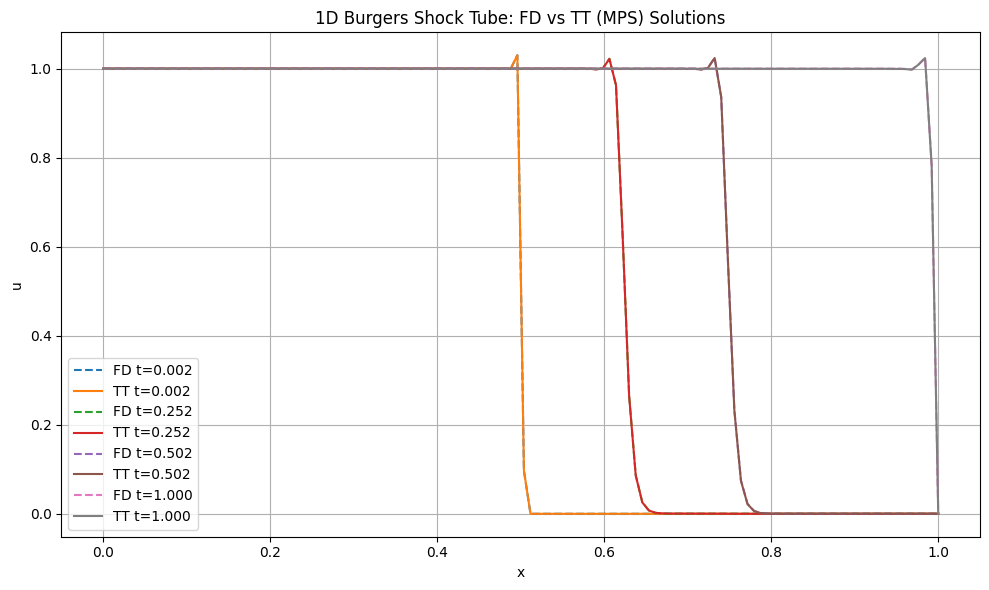

Final L2 error: 1.117345e-04, Linf error: 6.912980e-04


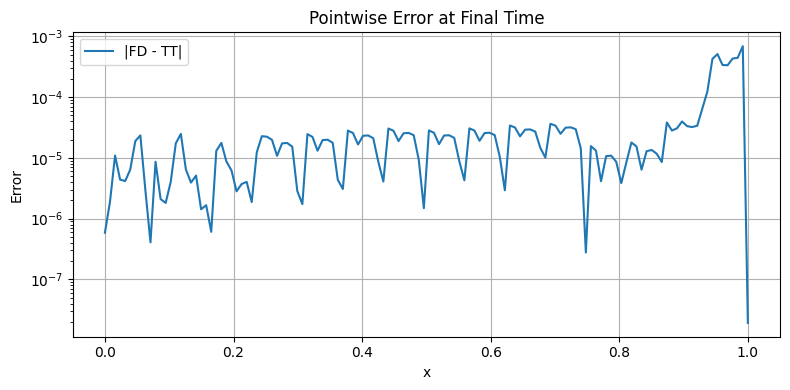

In [24]:
x = np.linspace(domain_a, domain_b, Nx)

plt.figure(figsize=(10, 6))
for i, t in enumerate(times):
    plt.plot(x, history_fd[i], '--', label=f'FD t={t:.3f}')
    plt.plot(x, history_tt[i], '-', label=f'TT t={t:.3f}')
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Burgers Shock Tube: FD vs TT (MPS) Solutions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final error
final_fd = history_fd[-1]
final_tt = history_tt[-1]
l2_error = np.linalg.norm(final_fd - final_tt) / np.sqrt(Nx)
linf_error = np.max(np.abs(final_fd - final_tt))
print(f"Final L2 error: {l2_error:.6e}, Linf error: {linf_error:.6e}")

plt.figure(figsize=(8, 4))
plt.plot(x, np.abs(final_fd - final_tt), label="|FD - TT|")
plt.xlabel("x")
plt.ylabel("Error")
plt.title("Pointwise Error at Final Time")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# # %% Initial Conditions for Navier-Stokes 2D CFD
# if os.path.exists(f"/content/data/{object}initcondx_{Lx+Ly}_{int_Re}.mps") and flag_init_conds:
#     ux = load_object(f"/content/data/{object}initcondx_{Lx+Ly}_{int_Re}.mps")
#     uy = load_object(f"/content/data/{object}initcondy_{Lx+Ly}_{int_Re}.mps")
# else:
#     ux = mask_mps * ux_val
#     uy = identity_mps(L=Lx + Ly) * 0.0
# %% Time Stepping

# # Solution for Navier-Stokes equation 2D CFD
# solution = euler_time_stepping(
#     ux=ux,
#     uy=uy,
#     nofq=[Lx, Ly],
#     dt=dt,
#     dx=dx,
#     dy=dy,
#     N=N,
#     nu=nu,
#     mask=mask_mps,
#     bdtrunc=BD_LIMIT(),
#     opt_method=method,
#     opt_accuracy=opt_acc,
#     opt_iter=opt_iter,
#     opt_paths_iter=100,
#     scheme=timestep_scheme,
#     saveit=None,
#     UID=var,
# )


# save_object(solution, f"/content/results/Re_{int(Re)}_{method}_{var}.mpssol")